<a href="https://colab.research.google.com/github/iamatul1214/Reinforcement-learning/blob/main/MDP_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                          A coding introduction to the Markov Decision Process

In [ ]:
"""
Maze environment used in the first three modules of the course:
"Beginner to Master: Reinforcement Learning".
"""


from typing import Tuple, Dict, Optional, Iterable

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):
    """
    Description:
        The environment consists of a grid of (size x size) positions. The agent
        starts the episode in location (row=0, col=0) if the environment is instantiated
        without exploring starts or from a random location (different from the goal)
         if it is. The goal is always at (row=size-1, col=size-1).
    Observation:
        Type: MultiDiscrete(2)
        Num     Observation     Min     Max
        0       row coordinate    0       size-1
        1       col coordinate    0       size-1
    Actions:
        Type: Discrete(4)
        Num     Action
        0       Move up
        1       Move right
        2       Move down
        3       Move left
    Reward:
        If the environment is instantiated with shaped rewards, then at each time step
        the agent will receive a reward signal of the following magnitude:

            r = - steps_to_goal(current_state) / steps_to_goal(furthest_state)

        This ensures that the maximum reward awarded will be -1.0 and that at the goal
        the reward will be 0.

        If the environment is instantiated without shaped rewards, then at each time step
        the agent will receive a reward of -1.0 until it reaches the goal.
    Episode termination:
        The episode terminates when the agent reaches the goal state.
    """

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        """
        Initialize the environment.

        Args:
            exploring_starts: should the agent restart at a random location or not.
            shaped_rewards: should the environment shape the rewards.
            size: size of the maze. Will be of shape (size x size).
        """
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        """
        Take an action in the environment and observe the next transition.

        Args:
            action: An indicator of the action to be taken.

        Returns:
            The next transition.
        """
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        """
        Reset the environment to execute a new episode.

        Returns: State representing the initial position of the agent.
        """
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        """
        Render a state of the environment.

        Args:
            mode: one of 'human' or 'rgb_array'. Human added only for compatibility.
            All rendering will be done in 'rgb arrays' via NumPy.

        Returns:
            A numpy.ndarray or None.

        """
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        """
        Clean up resources before shutting down the environment.

        Returns: None.
        """
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        """
        Compute the reward attained by taking action 'a' at state 's'.

        Args:
            state: the state of the agent prior to taking the action.
            action: the action taken by the agent.

        Returns:
            A float representing the reward signal received by the agent.

        """
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        """

        Simulate (without taking) a step in the environment.

        Args:
            state: the state of the agent prior to taking the action.
            action: the action to simulate the step with.

        Returns:
            The next transition.

        """
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        """
        Gets the next state after the agent performs action 'a' in state 's'. If there is a
        wall in the way, the next state will be the same as the current.

        Args:
            state: current state (before taking the action).
            action: move performed by the agent.

        Returns: a State instance representing the new state.
        """
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        """
        Creates a representation of the maze as a dictionary where the keys are
        the states available to the agent and the values are lists of adjacent
        states.

        Args:
            size: number of elements of each side in the square grid.

        Returns: the adjacency list dictionary.
        """

        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        """
        Compute the distance to the goal from all other positions in the maze using Dijkstra's
        algorithm.

        Args:
            goal: A tuple representing the location of the goal in a two-dimensional grid.
            maze: A dictionary holding the adjacency lists of all locations in the
            two-dimensional grid.

        Returns: A (H x W) numpy array holding the minimum number of moves for each position
        to reach the goal.

        """
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances

env = Maze()
env.reset()
env.render(mode='rgb_array')


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 22,  36,  71],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:

import os
Root = "/content/drive/MyDrive/Reinforcement learning/"
os.chdir(Root)
!pwd

/content/drive/MyDrive/Reinforcement learning


In [ ]:
!ls

 envs_1.py  'MDP introduction.ipynb'   __pycache__


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import sys
sys.path.append(Root)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import gym
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
# from envs import Maze
%matplotlib inline

In [ ]:
env = Maze()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## reset the enviornment
initial_state = env.reset()
print(f"The new episode will stat is state: {initial_state}")

The new episode will stat is state: (0, 0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


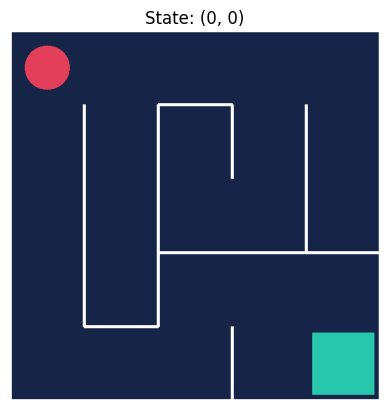

In [ ]:
## generate an image that represents the current state of the environment, in the form on np.ndarray
frame = env.render(mode = "rgb_array")
plt.axis("off")
plt.title(f"State: {initial_state}")
plt.imshow(frame)

## This method applies the action selected by the agent in the environment, to modify it. In response, the environment returns a tuple of four objects:

* The next state
*  The reward obtained
* (bool) if the task has been completed
* any other relevant information in a python dictionary

In [ ]:
action = 2
next_state,reward,done,info = env.step(action)
print(f"After moving down 1 row, the agent is in state: {next_state}")
print(f"After moving down 1 row, we got a reward of: {reward}")
print("After moving down 1 row, the task is", "" if done else "not", "finished")

After moving down 1 row, the agent is in state: (1, 0)
After moving down 1 row, we got a reward of: -1.0
After moving down 1 row, the task is not finished


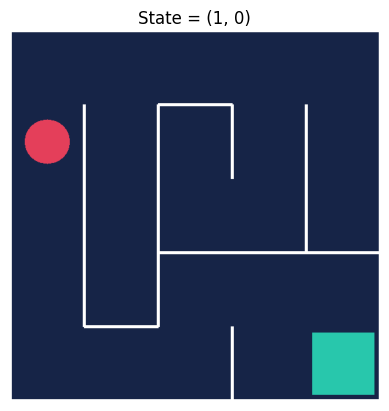

In [ ]:
## Now let's see visually where is the agent
frame = env.render(mode = "rgb_array")
plt.axis('off')
plt.title(f"State = {next_state}")
plt.imshow(frame)

In [ ]:
## Now let's close the environment
env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Maze environment: Find the exit.
* In this section we are going to familiarize ourselves with the environment that we'll use in the lessons 2 (dynamic programming), 3 (Monte Carlo methods) and 4 (temporal difference methods). This environment is perfect for learning the basics of Reinforcement Learning because:

* It has few states (25)
Transitions between states are deterministic (
)
All rewards are the same (-1) until the episode concludes. Thus facilitating the study of the value and action-value functions
* Through this environment, we are going to review the concepts seen in lesson 1 (The Markov decision process):

* States and state space
* Actions and action space
* Trajectories and episodes
* Rewards and returns
* Policy

The environment is a maze of 5x5 cells, in which the goal of the agent is to find the exit, located in the lower right corner, in the cell (4,4). In the image, the exit is colored in light green.

* To reach the exit, the agent can take four different actions: move up, move down, move left and move right.

In [ ]:
## create the environment
env = Maze()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(f"The intitial state is {env.reset()}")
print(f"THe space state os of type {env.observation_space}")

The intitial state is (0, 0)
THe space state os of type MultiDiscrete([5 5])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(f" An example of valid action is : {env.action_space.sample()}")
print(f"The action state is of type: {env.action_space}")

 An example of valid action is : 0
The action state is of type: Discrete(4)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Trajectories and episodes
* A trajectory is the sequence generated by moving from one state to another (both arbitrary)


Let's generate a trajectory of 3 moves in code:

In [ ]:
env = Maze()
state = env.reset()
trajectory = []
for _ in range(3):
  action = env.action_space.sample()
  next_state,reward,done,extra_info = env.step(action)
  trajectory.append([state,action,reward,done,next_state])
  state = next_state
env.close()

print(f"We have generated our first trajectory = {trajectory}")

We have generated our first trajectory = [[(0, 0), 1, -1.0, False, (0, 1)], [(0, 1), 0, -1.0, False, (0, 1)], [(0, 1), 2, -1.0, False, (1, 1)]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# An episode is a trajectory that goes from the initial state of the process to the final one:


* where T is the terminal state.

Let's generate a whole episode in code:

In [ ]:
env = Maze()
state = env.reset()
episode = []
while not done:
  action = env.action_space.sample()
  next_state,reward,done,extra_info = env.step(action)
  episode.append([state,action,reward,done,next_state])
  state = next_state
env.close()

print(f"we have generated our first episode = {episode}")

we have generated our first episode = [[(0, 0), 1, -1.0, False, (0, 1)], [(0, 1), 2, -1.0, False, (1, 1)], [(1, 1), 0, -1.0, False, (0, 1)], [(0, 1), 0, -1.0, False, (0, 1)], [(0, 1), 3, -1.0, False, (0, 0)], [(0, 0), 1, -1.0, False, (0, 1)], [(0, 1), 3, -1.0, False, (0, 0)], [(0, 0), 2, -1.0, False, (1, 0)], [(1, 0), 2, -1.0, False, (2, 0)], [(2, 0), 1, -1.0, False, (2, 0)], [(2, 0), 3, -1.0, False, (2, 0)], [(2, 0), 3, -1.0, False, (2, 0)], [(2, 0), 2, -1.0, False, (3, 0)], [(3, 0), 0, -1.0, False, (2, 0)], [(2, 0), 2, -1.0, False, (3, 0)], [(3, 0), 2, -1.0, False, (4, 0)], [(4, 0), 2, -1.0, False, (4, 0)], [(4, 0), 2, -1.0, False, (4, 0)], [(4, 0), 3, -1.0, False, (4, 0)], [(4, 0), 2, -1.0, False, (4, 0)], [(4, 0), 2, -1.0, False, (4, 0)], [(4, 0), 2, -1.0, False, (4, 0)], [(4, 0), 0, -1.0, False, (3, 0)], [(3, 0), 0, -1.0, False, (2, 0)], [(2, 0), 2, -1.0, False, (3, 0)], [(3, 0), 3, -1.0, False, (3, 0)], [(3, 0), 1, -1.0, False, (3, 0)], [(3, 0), 0, -1.0, False, (2, 0)], [(2, 0), 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Rewards and returns
* A reward is numerical feedback that the environment generates when the agent takes an action a in a state s:


Let's generate a reward from the environment:

In [ ]:
env = Maze()
state = env.reset()
action = env.action_space.sample()
_,reward,_,_ = env.step(action)
print(f"We achieved a reward of {reward} by taking action {action} in state {state}")

We achieved a reward of -1.0 by taking action 3 in state (0, 0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# The return associated with a moment in time t is the sum (discounted) of rewards that the agent obtains from that moment. We are going to calculate
, G that is, the return to the beginning of the episode:


Let's assume that the discount factor : G=0.99

In [ ]:
env = Maze()
state = env.reset()
done = False
gamma = 0.99
G_0 = 0
t = 0
while not done:
    action = env.action_space.sample()
    _, reward, done, _ = env.step(action)
    G_0 += gamma ** t * reward
    t += 1
env.close()

print(
    f"""It took us {t} moves to find the exit,
    and each reward r(s,a)=-1, so the return amounts to {G_0}""")

It took us 499 moves to find the exit, 
    and each reward r(s,a)=-1, so the return amounts to -99.3363148442005


# Policy
## A policy is a function that gives the probability of an action given the current state. The function takes the state and action as inputs and returns a float in [0,1].

Since in practice we will need to compute the probabilities of all actions, we will represent the policy as a function that takes the state as an argument and returns the probabilities associated with each of the actions. Thus, if the probabilities are:

[0.5, 0.3, 0.1]

we will understand that the action with index 0 has a 50% probability of being chosen, the one with index 1 has 30% and the one with index 2 has 10%.

Let's code a policy function that chooses actions randomly:

In [ ]:
def random_policy(state):
  return np.array([0.25]*4 )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## Let's play an episode with our random policy
env = Maze()
state = env.reset()

In [ ]:
action_probabilities = random_policy(state)

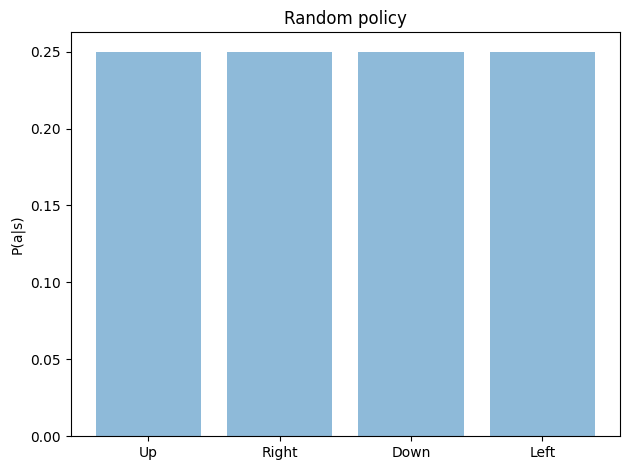

In [ ]:
objects = ("Up","Right","Down","Left")
y_pos = np.arange(len(objects))

plt.bar(y_pos,action_probabilities, alpha = 0.5)
plt.xticks(y_pos,objects)
plt.ylabel("P(a|s)")
plt.title('Random policy')
plt.tight_layout()
plt.show()

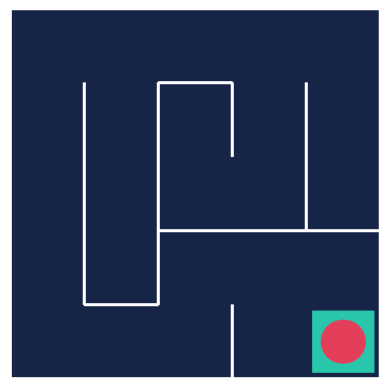

In [ ]:
## using the policy to play an episode
env.reset()
done = False
img = plt.imshow(env.render(mode = "rgb_array"))
t = 0
while not done:
  action = np.random.choice(range(4), 1, p=action_probabilities)
  _,_,done,_ = env.step(action)
  img.set_data(env.render(mode = "rgb_array"))
  plt.axis("off")
  display.display(plt.gcf())
  display.clear_output(wait = True)
  t+=1
env.close()

In [ ]:
print(f"total time taken = {t}")

total time taken = 76
